# Ray et al 2013 Extract-Transform-Load
**Authorship:**
Adam Klie, *08/11/2022*
***
**Description:**
Notebook to extract, transform, and load data from the Ray et al (2013) dataset.
***

In [59]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import eugene as eu
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

# Download and load in the dataset to a raw `SeqData` object

In [60]:
# Load in the downloaded data, or download it if it's not there
sdata_raw = eu.datasets.ray13()

Dataset ray13 norm_data.txt.gz has already been dowloaded.


In [61]:
# Subset to set type (A or B)
sdata_setA_raw = sdata_raw[sdata_raw.seqs_annot["Probe_Set"] == "SetA"]
sdata_setB_raw = sdata_raw[sdata_raw.seqs_annot["Probe_Set"] == "SetB"]

In [62]:
# Save raw versions of these three
sdata_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_raw.h5sd"))
sdata_setA_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_raw.h5sd"))
sdata_setB_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_raw.h5sd"))

# Preprocess the training set

## Preprocess the seqs
- Padded elements of sequences are replaced with a one hot encoded value of 0.25 spanning each base.

In [63]:
eu.pp.one_hot_encode_data(sdata_setA_raw, alphabet="RNA", seq_align="center", fill_value=0.25)
eu.pp.one_hot_encode_data(sdata_setB_raw, alphabet="RNA", seq_align="center", fill_value=0.25)

One-hot-encoding sequences:   0%|          | 0/120326 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 120326 ohe_seqs added


One-hot-encoding sequences:   0%|          | 0/121031 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 121031 ohe_seqs added


## Preprocess the targets
- The values of probe intensities are clamped at 99.95% percentile per binding protein to eliminate outliers and balance the data.
- The probe intensities are normalized to a mean of 0 and a standard deviation of 1.

In [64]:
# Get a list of only the target columns
target_mask = sdata_setA_raw.seqs_annot.columns.str.contains("RNCMPT")
target_cols = sdata_setA_raw.seqs_annot.columns[target_mask]
random_cols = np.random.choice(target_cols, 9)
len(target_cols)

244

In [65]:
# Split only those training sequences in SetA into train and validation sets
eu.pp.train_test_split_data(sdata_setA_raw, train_key="train_val", split=0.8)

SeqData object modified:
    seqs_annot:
        + train_val


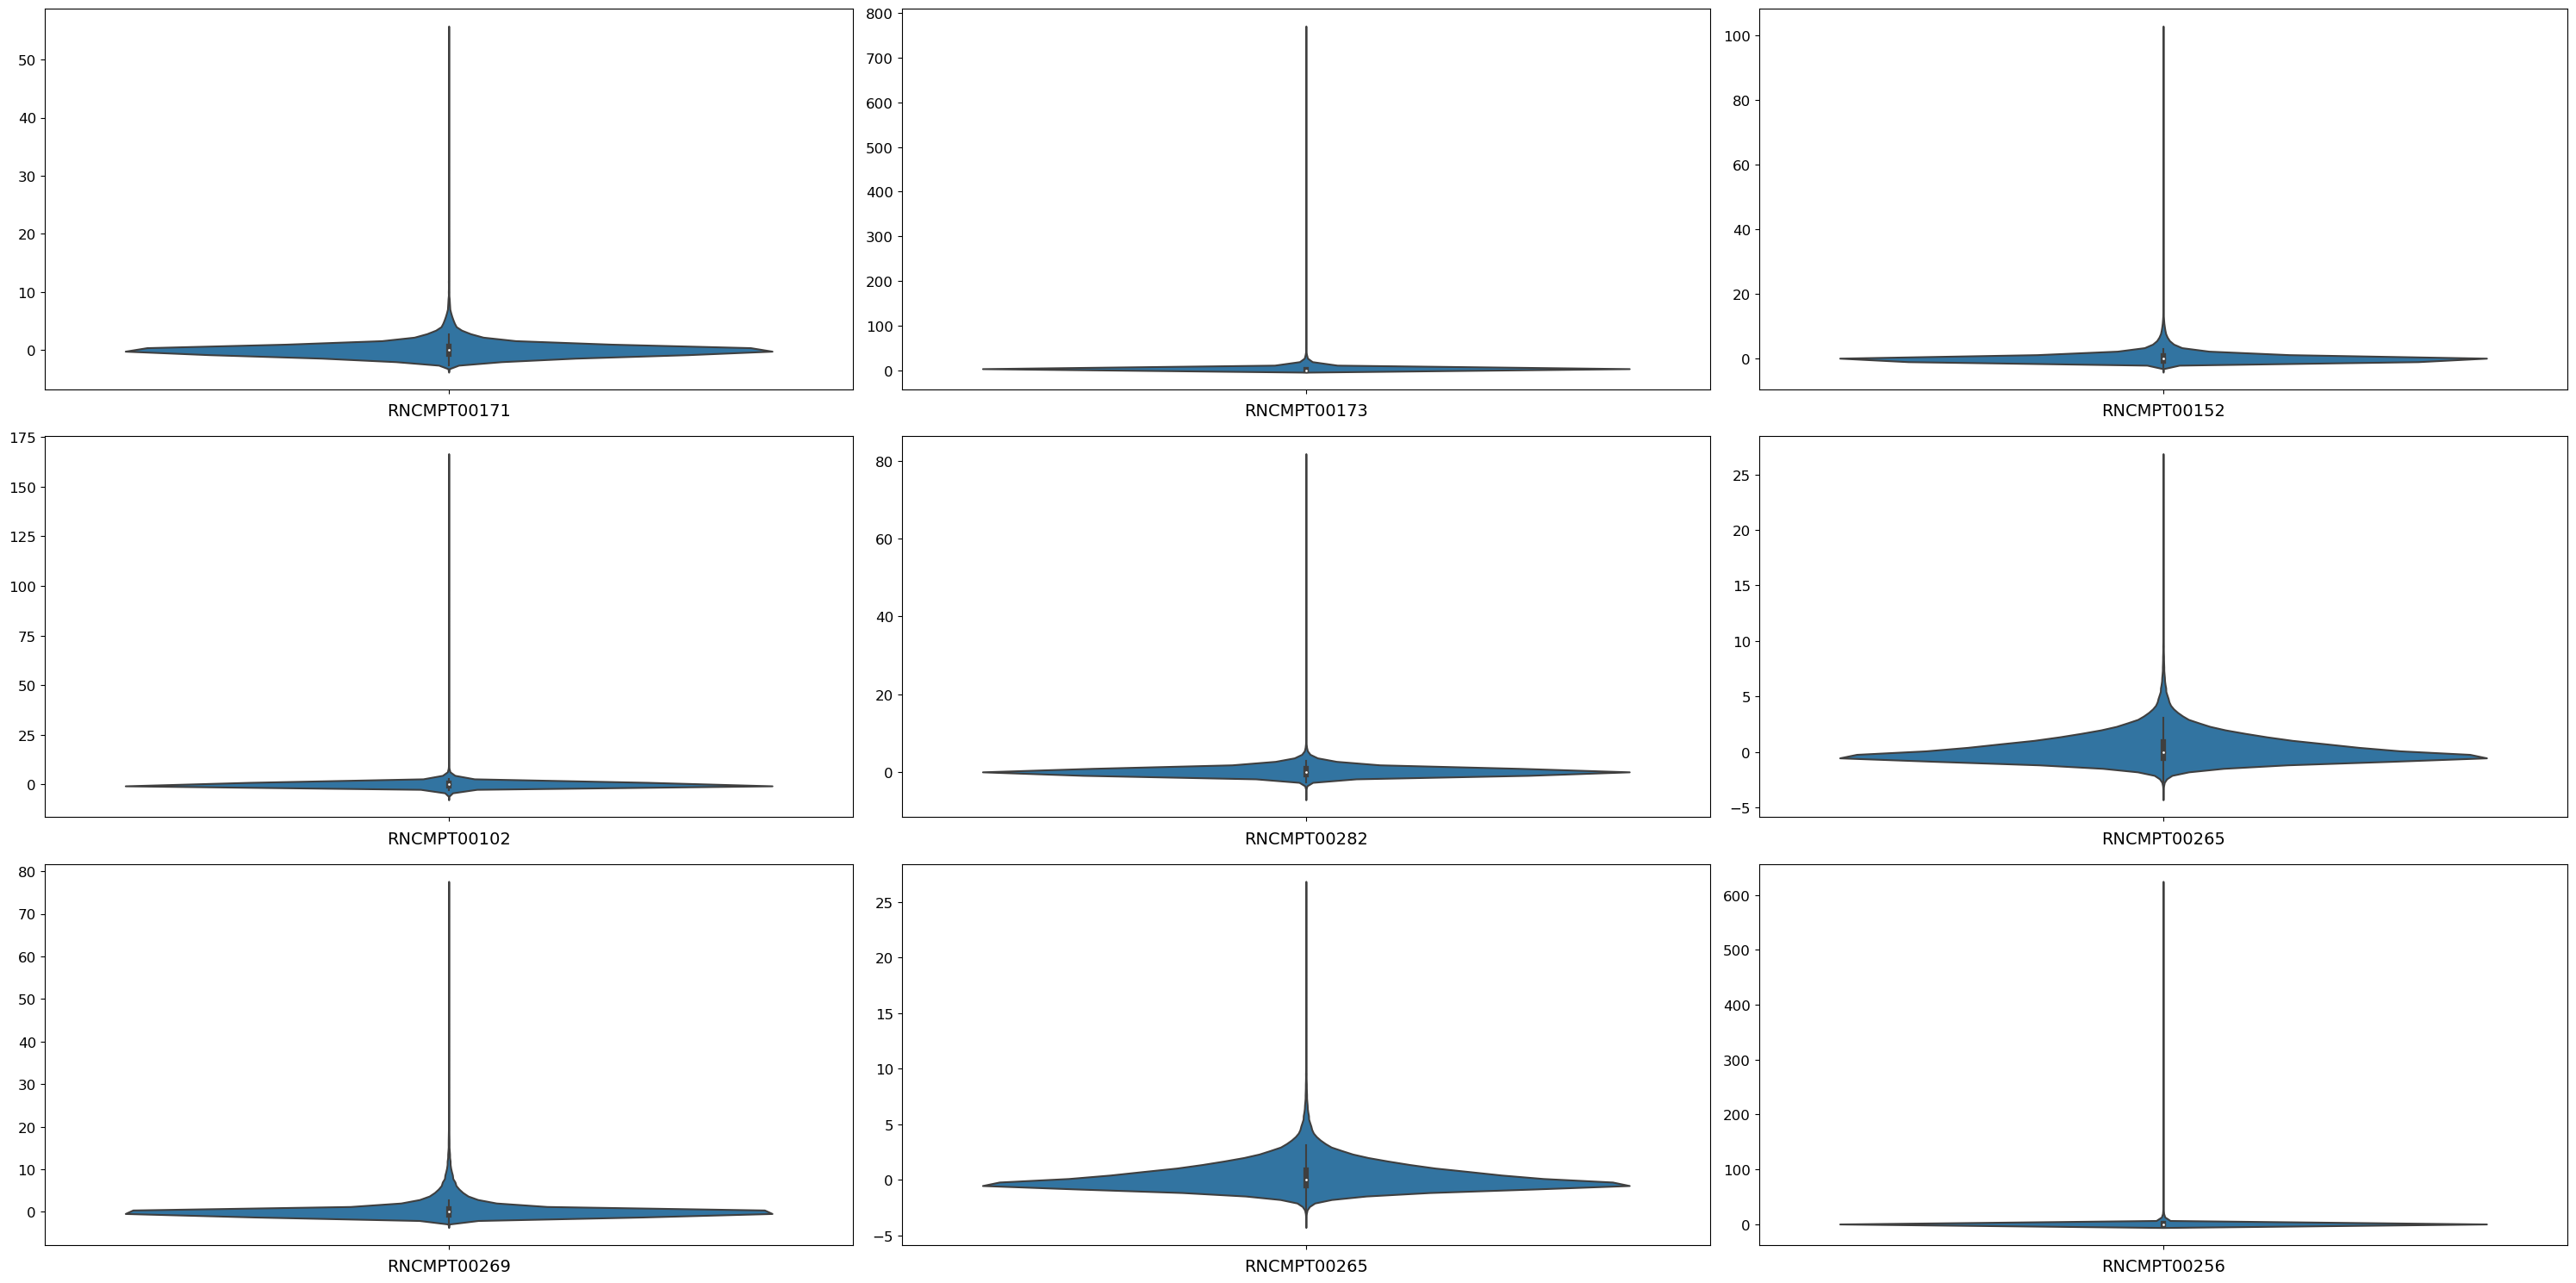

In [66]:
# Plot the distribution of the targets
eu.pl.violinplot(
    sdata_setA_raw, 
    keys=random_cols
)

In [ ]:
# Clamp the targets based on percentiles
eu.pp.clamp_percentiles(sdata_setA_raw, percentile=0.9995, target_list=target_cols, train_key="train_val", store_clamp_nums=True)

In [ ]:
sdata_setA_raw.seqs_annot[random_cols].describe()

,RNCMPT00083,RNCMPT00274,RNCMPT00023,RNCMPT00053,RNCMPT00034,RNCMPT00041,RNCMPT00085,RNCMPT00063,RNCMPT00172
count,120306.000000,120302.000000,119695.000000,119710.000000,119718.000000,119690.000000,119693.000000,119696.000000,119711.000000
mean,1.988981,0.726027,0.210231,0.390251,0.542800,0.723915,0.599411,0.009522,0.238678
std,9.462394,3.242694,1.615755,1.950834,2.442528,3.123143,2.511606,1.889484,1.410418
min,-2.935993,-6.393573,-2.865269,-3.374266,-5.289956,-3.831198,-6.974339,-15.055875,-4.265759
25%,-0.542064,-0.582195,-0.717118,-0.602999,-0.605851,-0.562101,-0.552106,-0.687755,-0.614478
50%,-0.000265,0.000000,-0.002344,-0.002938,-0.002791,0.000029,0.001883,-0.001228,-0.003081
75%,1.044569,0.778890,0.633544,0.802508,0.788905,0.906776,0.976731,0.662253,0.754474
max,195.570641,48.138323,16.105892,27.950163,30.437903,48.269444,34.192218,35.633579,14.265753


In [ ]:
sdata_setA_raw.uns["clamp_nums"][random_cols]

RNCMPT00083    195.570641
RNCMPT00274     48.138323
RNCMPT00023     16.105892
RNCMPT00053     27.950163
RNCMPT00034     30.437903
RNCMPT00041     48.269444
RNCMPT00085     34.192218
RNCMPT00063     35.633579
RNCMPT00172     14.265753
Name: 0.9995, dtype: float64

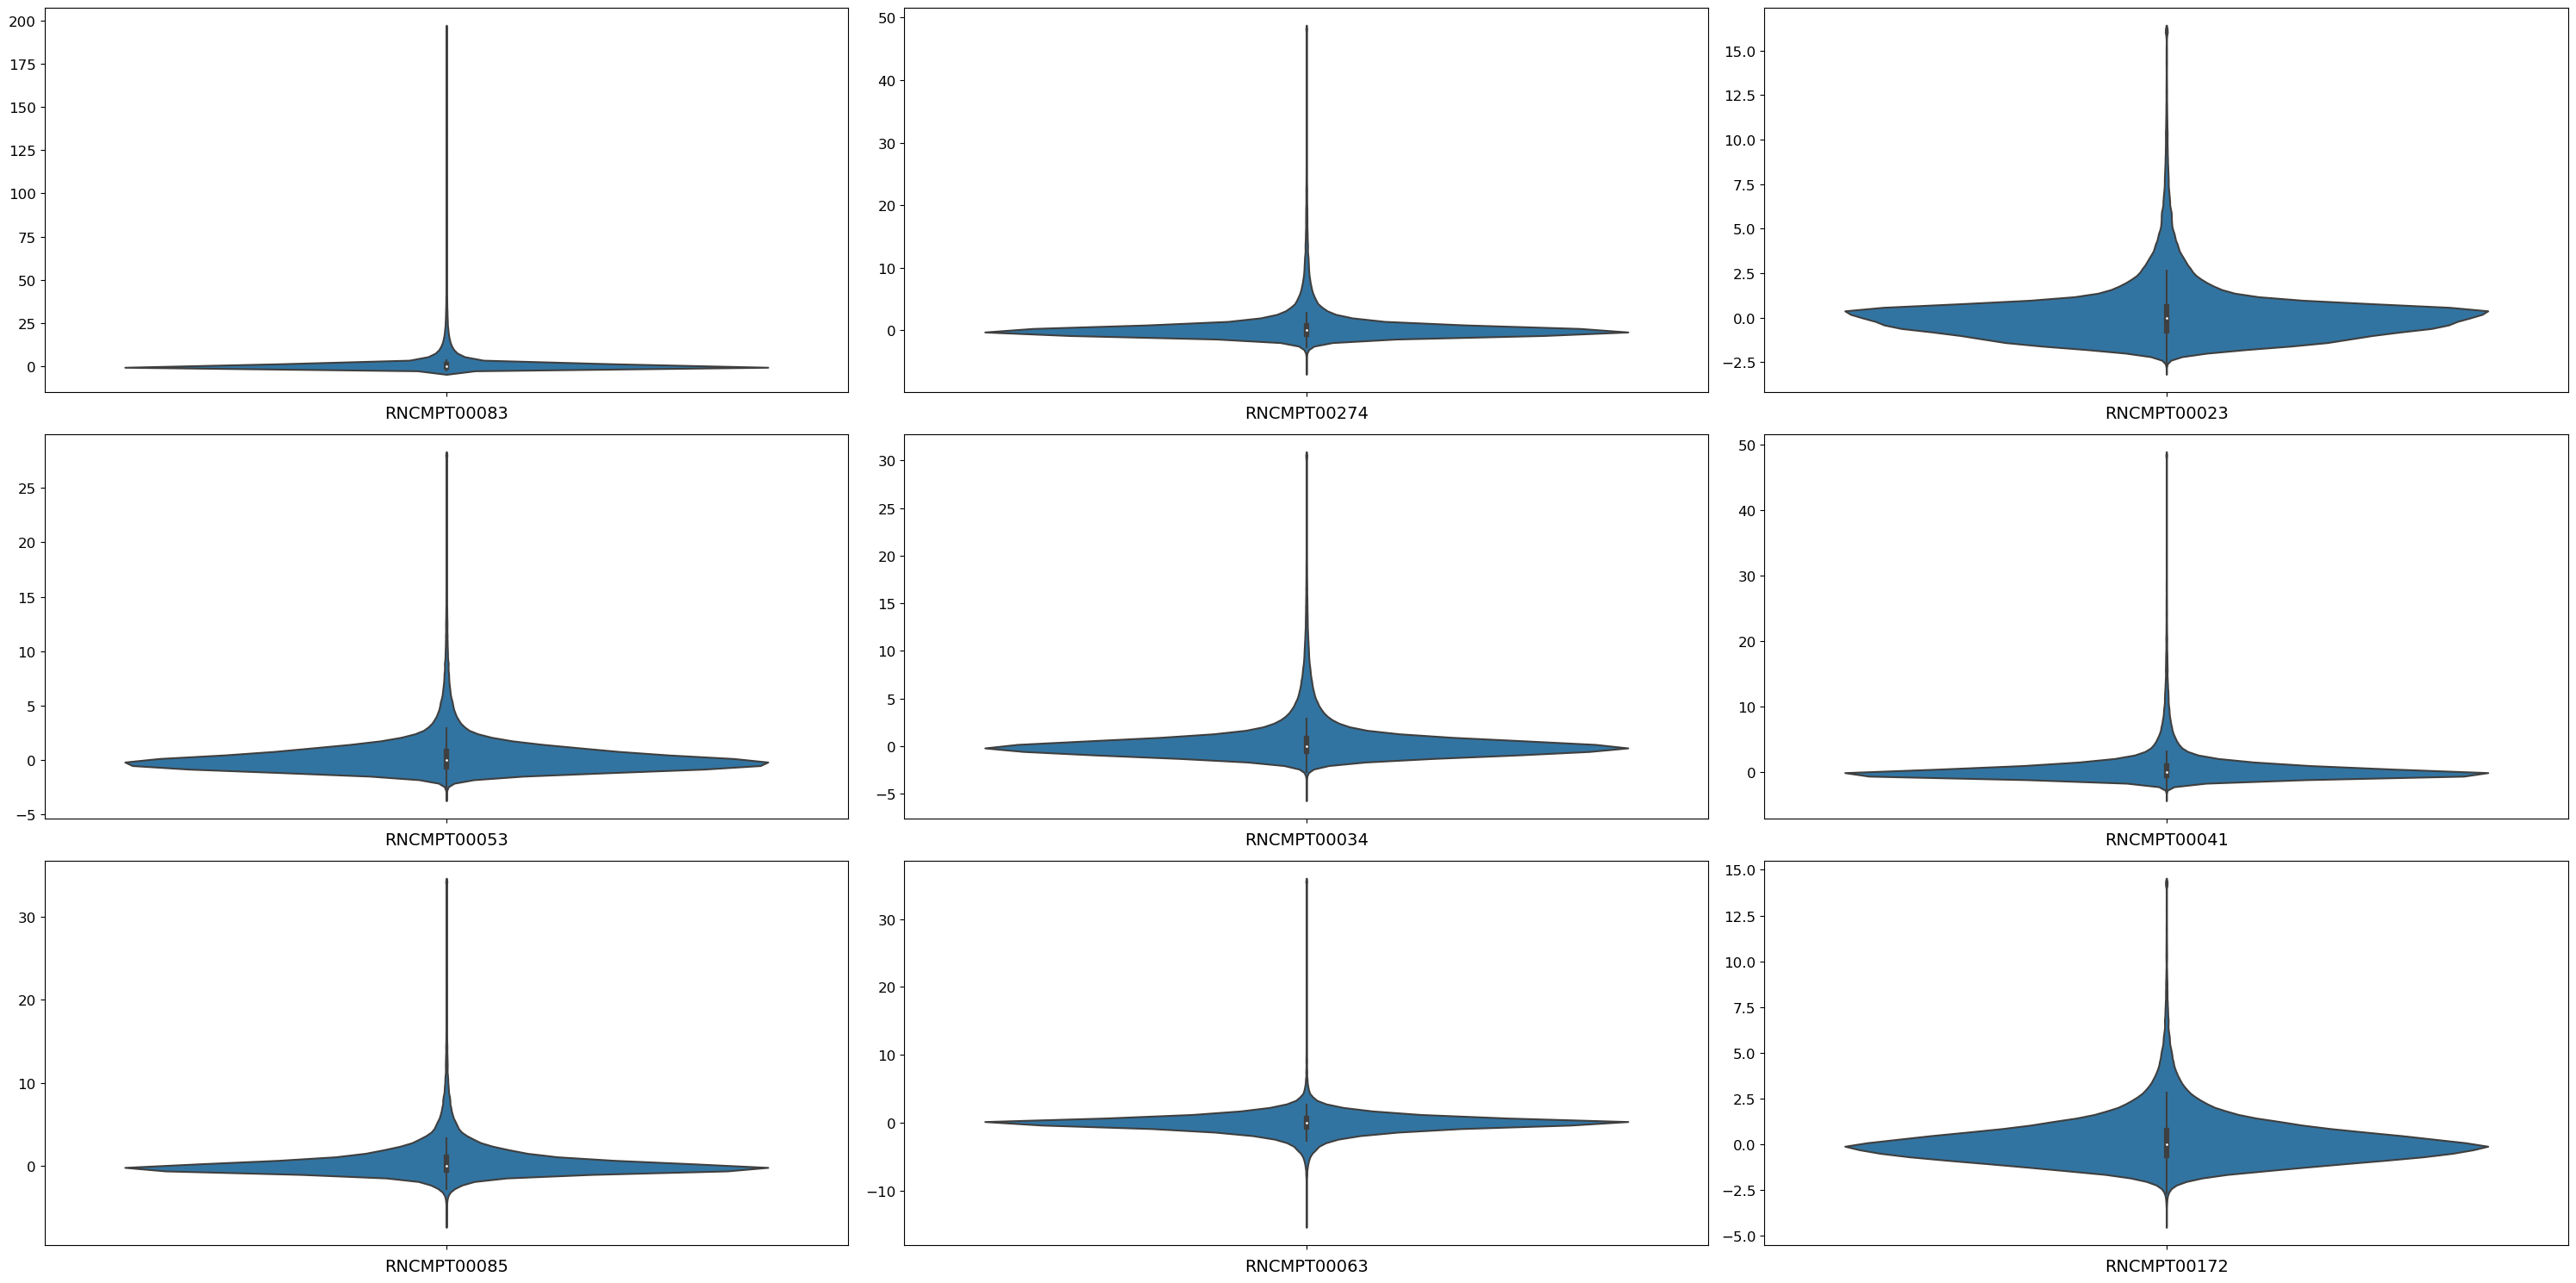

In [ ]:
eu.pl.violinplot(
    sdata_setA_raw, 
    keys=random_cols
)

In [ ]:
eu.pp.scale_targets(sdata_setA_raw, targets=target_cols, train_key="train_val", suffix=False, store_scaler=True)

In [ ]:
sdata_setA_raw.seqs_annot[target_cols].describe()

,RNCMPT00100,RNCMPT00101,RNCMPT00102,RNCMPT00103,RNCMPT00104,RNCMPT00105,RNCMPT00106,RNCMPT00107,RNCMPT00108,RNCMPT00109,...,RNCMPT00008,RNCMPT00090,RNCMPT00091,RNCMPT00093,RNCMPT00094,RNCMPT00095,RNCMPT00096,RNCMPT00097,RNCMPT00099,RNCMPT00009
count,120252.000000,120262.000000,120285.000000,120313.000000,120313.000000,120179.000000,120279.000000,120316.000000,120304.000000,120304.000000,...,79089.000000,120324.000000,119649.000000,120326.000000,120254.000000,120213.000000,120319.000000,118832.000000,120168.000000,74561.000000
mean,-0.000892,0.001110,-0.000894,-0.001209,-0.000981,-0.000830,0.000346,0.000853,0.002044,0.001766,...,0.000686,-0.000100,0.000048,-0.002575,-0.001236,-0.000512,-0.001675,-0.001018,-0.000980,0.003283
std,0.997410,1.020525,1.002307,0.978627,0.982749,0.998109,1.000649,1.005483,1.010201,1.009679,...,1.000385,1.001129,1.002171,0.983708,0.994508,0.986762,0.986130,0.991359,0.996083,0.998293
min,-0.708462,-0.514076,-5.600323,-1.232183,-1.532100,-4.710454,-0.407043,-0.383484,-0.450989,-0.354403,...,-2.861418,-11.530205,-2.247183,-0.734555,-2.070196,-0.839285,-0.888454,-0.709476,-1.016065,-6.098262
25%,-0.333029,-0.186311,-0.550346,-0.254521,-0.289589,-0.487386,-0.223169,-0.229103,-0.250207,-0.219683,...,-0.540149,-0.316775,-0.596122,-0.276718,-0.499617,-0.253152,-0.261539,-0.237884,-0.308991,-0.607111
50%,-0.231536,-0.131478,-0.072450,-0.058678,-0.105945,-0.167116,-0.184461,-0.192930,-0.202766,-0.182754,...,-0.160582,-0.033841,-0.130832,-0.135262,-0.143978,-0.134833,-0.115630,-0.168271,-0.174184,-0.008076
75%,-0.061493,-0.053698,0.462122,0.117865,0.142312,0.346754,-0.111788,-0.125165,-0.120029,-0.114832,...,0.328262,0.295650,0.309110,0.025993,0.271894,0.027540,0.039491,-0.044344,0.008478,0.604184
max,16.246738,24.719098,10.503280,27.510587,28.689711,9.518592,19.219405,17.907541,17.026719,19.135278,...,10.981691,15.103138,9.182879,22.778451,18.856346,29.993462,24.794541,22.160394,19.009158,5.143852


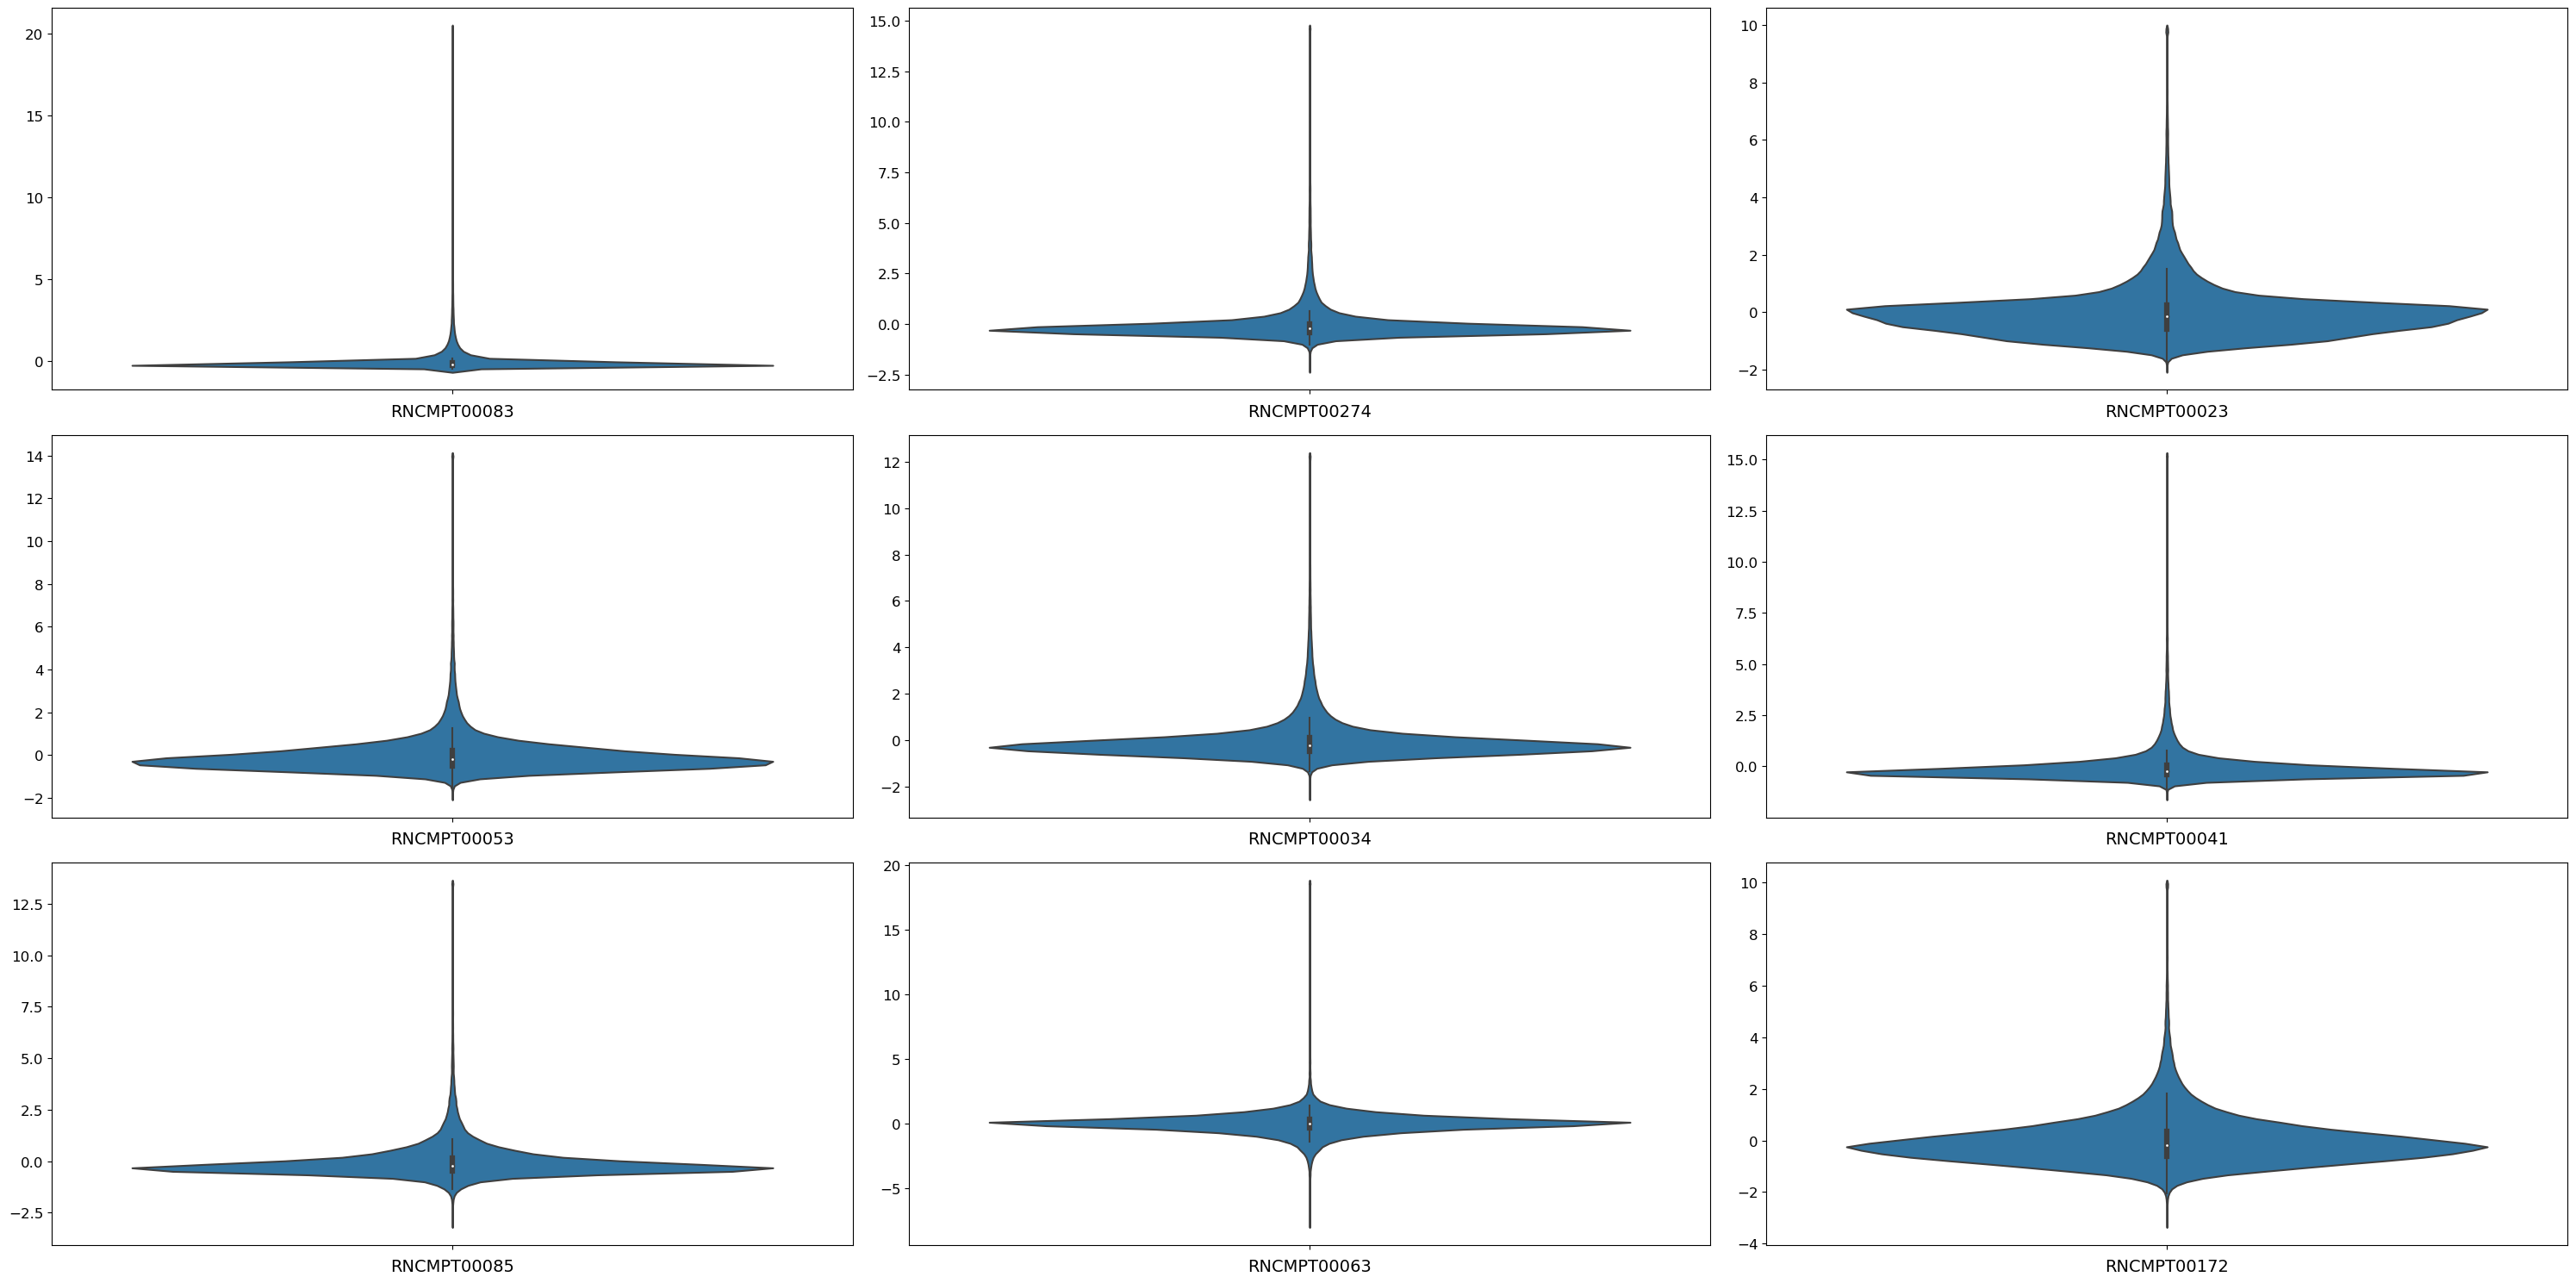

In [ ]:
eu.pl.violinplot(
    sdata_setA_raw, 
    keys=random_cols
)

# Preprocess the test set

In [ ]:
eu.pp.clamp_percentiles(sdata_setB_raw, target_list=target_cols, clamp_nums=sdata_setA_raw.uns["clamp_nums"])

In [ ]:
sdata_setB_raw.seqs_annot[random_cols].describe()

,RNCMPT00083,RNCMPT00274,RNCMPT00023,RNCMPT00053,RNCMPT00034,RNCMPT00041,RNCMPT00085,RNCMPT00063,RNCMPT00172
count,121013.000000,121013.000000,120355.000000,120382.000000,120389.000000,120359.000000,120356.000000,120360.000000,120380.000000
mean,1.983273,0.715936,0.211977,0.398939,0.549823,0.713962,0.591293,0.018008,0.245647
std,9.143676,3.219100,1.603130,1.933207,2.481810,3.049996,2.483866,1.964949,1.430051
min,-2.658412,-8.055518,-2.741918,-3.654633,-4.631185,-3.242275,-7.161176,-14.143705,-3.602022
25%,-0.540499,-0.581255,-0.714755,-0.596129,-0.600505,-0.564771,-0.548686,-0.684591,-0.615747
50%,0.000387,0.000000,0.001582,0.002876,0.002711,0.000013,-0.001720,0.001589,0.002784
75%,1.068771,0.766737,0.640411,0.807267,0.793498,0.918776,0.973077,0.664185,0.762383
max,195.570641,48.138323,16.105892,27.950163,30.437903,48.269444,34.192218,35.633579,14.265753


In [ ]:
eu.pp.scale_targets(sdata_setB_raw, targets=target_cols, scaler=sdata_setA_raw.uns["scaler"], suffix=False)

In [ ]:
sdata_setB_raw.seqs_annot[random_cols].describe()

,RNCMPT00083,RNCMPT00274,RNCMPT00023,RNCMPT00053,RNCMPT00034,RNCMPT00041,RNCMPT00085,RNCMPT00063,RNCMPT00172
count,121013.000000,121013.000000,120355.000000,120382.000000,120389.000000,120359.000000,120356.000000,120360.000000,120380.000000
mean,-0.001947,-0.003654,0.001492,0.000572,0.001006,-0.003997,-0.000862,0.003082,0.003052
std,0.959754,0.990480,0.988356,0.978520,1.012424,0.971268,0.994698,1.027320,1.009622
min,-0.489155,-2.702531,-1.819633,-2.051201,-2.112524,-1.263856,-3.105443,-7.400984,-2.713417
25%,-0.266851,-0.402785,-0.569854,-0.503096,-0.468257,-0.411208,-0.457382,-0.364253,-0.605095
50%,-0.210078,-0.223939,-0.128220,-0.199902,-0.222182,-0.231353,-0.238342,-0.005502,-0.168410
75%,-0.097936,0.011977,0.265629,0.207252,0.100410,0.061226,0.152028,0.340918,0.367870
max,20.317692,14.587674,9.800354,13.946013,12.193487,15.139998,13.455081,18.623713,9.901302


In [ ]:
sdata_setA_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_processed.h5sd"))
sdata_setB_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_processed.h5sd"))

Unsupported type for scaler
Unsupported type for scaler


# Generating a presence/absence matrix per probe

In [34]:
from eugene.predict._metrics import generate_all_possible_kmers, kmer_in_seqs

In [36]:
a_probes = pd.Series(sdata_setA_raw.seqs)
b_probes = pd.Series(sdata_setB_raw.seqs)
kmers = generate_all_possible_kmers(n=7, alphabet="ACGU")
len(a_probes), len(b_probes), len(kmers)

(120326, 121031, 16384)

In [37]:
a_hits = np.array([a_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "SetA_binary"), a_hits)
a_hits.shape, np.all((a_hits == 1).sum(axis=1) >= 155)

Searching for kmers in probes:   0%|          | 0/16384 [00:00<?, ?it/s]

: 

: 

In [ ]:
b_hits = np.array([b_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "SetB_binary"), b_hits)
b_hits.shape,  np.all((b_hits == 1).sum(axis=1) >= 155)

Searching for kmers in probes:   0%|          | 0/16384 [00:00<?, ?it/s]

# Generate multitask ready data

In [ ]:
nan_percents = sdata_setA_raw.seqs_annot[target_cols].isna().sum(axis=0).sort_values(ascending=False)/sdata_setA_raw.seqs_annot.shape[0]

In [ ]:
remove_cols = nan_percents[nan_percents > 0.01].index
keep_cols = target_cols.drop(remove_cols)

In [58]:
sdata_setA_raw.seqs_annot = sdata_setA_raw.seqs_annot.drop(remove_cols, axis=1)

KeyError: "['RNCMPT00145' 'RNCMPT00060' 'RNCMPT00009' 'RNCMPT00008' 'RNCMPT00015'\n 'RNCMPT00129' 'RNCMPT00144' 'RNCMPT00058' 'RNCMPT00061' 'RNCMPT00154'\n 'RNCMPT00097'] not found in axis"

In [32]:
keep_rows = np.where(sdata_setA_raw.seqs_annot[keep_cols].isna().sum(axis=1) == 0)[0]
sdata_setA_MT = sdata_setA_raw[keep_rows]

In [34]:
sdata_setB_raw.seqs_annot = sdata_setB_raw.seqs_annot.drop(nan_percents[nan_percents > 0.01].index, axis=1)
sdata_setB_raw.seqs_annot

,RNCMPT00100,RNCMPT00101,RNCMPT00102,RNCMPT00103,RNCMPT00104,RNCMPT00105,RNCMPT00106,RNCMPT00107,RNCMPT00108,RNCMPT00109,...,RNCMPT00087,RNCMPT00088,RNCMPT00089,RNCMPT00090,RNCMPT00091,RNCMPT00093,RNCMPT00094,RNCMPT00095,RNCMPT00096,RNCMPT00099
Probe_ID,,,,,,,,,,,,,,,,,,,,,
RBD_v3_120327,0.159149,-0.153696,-0.170946,-0.057844,-0.395167,-1.310284,-0.195722,-0.083851,0.010943,-0.045436,...,-0.270491,0.404033,-0.059903,0.965863,-0.401737,-0.122105,-0.070216,-0.162430,0.122320,-0.102404
RBD_v3_120328,9.436790,-0.089102,0.118995,0.118706,-0.152561,-0.278771,-0.131623,-0.044752,-0.094921,-0.114905,...,-0.592447,0.222818,0.065942,0.005581,-0.816169,1.356601,3.245431,3.768369,5.094446,4.143937
RBD_v3_120329,-0.158667,0.232918,0.017430,-0.256294,-0.089002,-0.211420,-0.122403,-0.105555,0.237775,0.222192,...,-0.534383,0.292644,0.147595,0.070845,-0.625076,-0.006058,-0.018101,0.030085,0.009835,-0.114274
RBD_v3_120330,0.341500,3.226347,-0.606717,2.301566,1.987464,1.048949,-0.144837,-0.179665,-0.016713,-0.022391,...,1.723422,-0.008121,-0.239692,-0.154306,-1.212251,0.159730,1.299685,0.666730,0.234848,0.588431
RBD_v3_120331,-0.149190,0.134222,-0.674633,0.178318,-0.129883,0.011787,-0.238371,-0.251516,-0.282037,-0.225289,...,0.113559,0.044900,-0.126530,-0.042310,0.674980,0.924526,-0.446573,-0.464499,0.039491,-0.251399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RBD_v3_241353,0.071749,1.786997,0.502260,3.497169,3.380041,-0.115823,0.328753,0.169047,-0.079018,-0.084149,...,2.403728,-0.334847,-0.490299,-0.881249,-0.222327,1.539095,0.141164,0.354275,-0.132782,-0.143303
RBD_v3_241354,-0.308462,-0.209062,0.369478,0.113007,0.035961,1.134031,-0.200274,-0.202150,-0.210554,-0.216369,...,-0.506352,-0.336763,0.362326,0.840806,0.002768,-0.115394,-0.543379,-0.574715,0.051822,-0.402258
RBD_v3_241355,-0.121801,-0.187577,-0.307949,-0.114808,0.087234,-0.084052,-0.170218,-0.228477,-0.202702,-0.174236,...,-0.405425,-0.150050,-0.455339,-0.626681,0.141793,0.030894,-0.055259,-0.218886,-0.029041,-0.083340


---

# Scratch

In [32]:
sdata.seqs_annot.isna().sum(axis=1).sort_values(ascending=False)[:20]

seq133747    104
seq117002    103
seq092826    102
seq124203    102
seq061395    102
seq195223    102
seq113624    102
seq146323    101
seq093392    101
seq044638    100
seq088282    100
seq036382    100
seq083383    100
seq010609    100
seq005807    100
seq198815     99
seq171734     99
seq000748     99
seq233144     99
seq162007     99
dtype: int64